# MNIST Multi Class Classification


In [1]:
# Libraries
import numpy as np
import gzip
import struct
import matplotlib.pyplot as plt
import h5py

### Load Images

In [2]:
def load_images(filename, header_size=16, dtype=np.uint8):
    """Load images from a gzip-compressed file and return them as a matrix of pixels.

    Args:
        filename (str): Path to the gzip-compressed file containing the images.
        header_size (int): Number of bytes to read for the header information.
        dtype (type): Data type for the pixel values.

    Returns:
        np.ndarray: Matrix of pixel values where each row represents an image.
    """
    with gzip.open(filename, 'rb') as f:
        # Read header information
        _ignored, n_images, columns, rows = struct.unpack('>IIII', f.read(header_size))
        # Read all pixel values into a NumPy array
        all_pixels = np.frombuffer(f.read(), dtype=dtype)
    return all_pixels.reshape(n_images, columns * rows)

In [3]:
def prepend_bias(X, bias_value=1):
    """Prepend a column of bias values to the input matrix.

    Args:
        X (np.ndarray): Input matrix where each row is an observation.
        bias_value (int): The value to use for the bias column (default is 1).

    Returns:
        np.ndarray: Matrix with an additional column of bias values prepended.
    """
    return np.insert(X, 0, bias_value, axis=1)

### Load Labels

In [4]:
def load_labels(filename, header_size=8, dtype=np.uint8):
    """Load labels from a gzip-compressed file and return them as a one-column matrix.

    Args:
        filename (str): Path to the gzip-compressed file containing the labels.
        header_size (int): Number of bytes to skip for the header information (default is 8).
        dtype (type): Data type for the labels (default is np.uint8).

    Returns:
        np.ndarray: Array of labels with one column.
    """
    with gzip.open(filename, 'rb') as f:
        f.read(header_size)  # Skip the header bytes
        all_labels = f.read()
    return np.frombuffer(all_labels, dtype=dtype).reshape(-1, 1)

In [5]:
def one_hot_encode(Y, n_classes=10):
    """One-hot encode the labels.

    Args:
        Y (np.ndarray): Array of labels to encode.
        n_classes (int): Number of classes for encoding (default is 10).

    Returns:
        np.ndarray: One-hot encoded matrix where each row corresponds to a label.
    """
    Y = Y.flatten()
    n_labels = Y.size
    encoded_Y = np.zeros((n_labels, n_classes), dtype=np.uint8)
    encoded_Y[np.arange(n_labels), Y] = 1
    return encoded_Y

In [6]:
# 60000 images, each 785 elements (1 bias + 28 * 28 pixels)
X_train = prepend_bias(load_images("./data/train-images-idx3-ubyte.gz"))

# 10000 images, each 785 elements, with the same structure as X_train
X_test = prepend_bias(load_images("./data/t10k-images-idx3-ubyte.gz"))

# 60K labels, each a single digit from 0 to 9
Y_train_unencoded = load_labels("./data/train-labels-idx1-ubyte.gz")

# 60K labels, each consisting of 10 one-hot encoded elements
Y_train = one_hot_encode(Y_train_unencoded)

# 10000 labels, each a single digit from 0 to 9
Y_test = load_labels("./data/t10k-labels-idx1-ubyte.gz")

In [7]:
class LogisticRegression:
    def __init__(self, learning_rate=0.01, iterations=100, n_classes=10):
        """Initialize the logistic regression model.

        Args:
            learning_rate (float): Learning rate for gradient descent (default is 0.01).
            iterations (int): Number of iterations for training (default is 100).
            n_classes (int): Number of classes for classification (default is 10).
        """
        self.learning_rate = learning_rate
        self.iterations = iterations
        self.n_classes = n_classes
        self.w = None

    def sigmoid(self, z):
        """Compute the sigmoid of z."""
        return 1 / (1 + np.exp(-z))

    def forward(self, X):
        """Perform forward propagation."""
        weighted_sum = np.matmul(X, self.w)
        return self.sigmoid(weighted_sum)

    def classify(self, X):
        """Classify input samples using logistic regression."""
        y_hat = self.forward(X)
        labels = np.argmax(y_hat, axis=1)
        return labels.reshape(-1, 1)

    def loss(self, X, Y):
        """Compute the loss for logistic regression."""
        y_hat = self.forward(X)
        epsilon = 1e-10
        first_term = Y * np.log(y_hat + epsilon)
        second_term = (1 - Y) * np.log(1 - y_hat + epsilon)
        return -np.sum(first_term + second_term) / X.shape[0]

    def gradient(self, X, Y):
        """Compute the gradient of the loss function."""
        return np.matmul(X.T, (self.forward(X) - Y)) / X.shape[0]

    def report(self, iteration, X_train, Y_train, X_test, Y_test):
        """Print training progress and performance."""
        predictions = self.classify(X_test)
        matches = np.sum(predictions == Y_test)
        n_test_examples = Y_test.shape[0]
        accuracy = (matches / n_test_examples) * 100.0
        training_loss = self.loss(X_train, Y_train)
        if iteration % 20 == 0 or iteration == self.iterations - 1:
            print(f"{iteration} - Loss: {training_loss:.20f}, Accuracy: {accuracy:.2f}%")

    def train(self, X_train, Y_train, X_test, Y_test):
        """Train the logistic regression model."""
        self.w = np.zeros((X_train.shape[1], self.n_classes))
        for i in range(self.iterations):
            self.report(i, X_train, Y_train, X_test, Y_test)
            self.w -= self.gradient(X_train, Y_train) * self.learning_rate
        self.report(self.iterations, X_train, Y_train, X_test, Y_test)
        return self.w
    
    def test(self, X_test, Y_test):
        """Test the logistic regression model and print the accuracy."""
        predictions = self.classify(X_test)
        accuracy = np.mean(predictions == Y_test) * 100
        print(f"Test accuracy: {accuracy:.2f}%")
        return predictions

    def visualize_predictions(self, X_test, Y_test, predictions, num_images=10):
        """Visualize predictions and ground truth for a number of images.

        Args:
            X_test (np.ndarray): Testing features.
            Y_test (np.ndarray): True labels.
            predictions (np.ndarray): Model predictions.
            num_images (int): Number of images to display (default is 10).
        """
        plt.figure(figsize=(10, 2))
        for i in range(num_images):
            plt.subplot(1, num_images, i + 1)
            plt.imshow(X_test[i, 1:].reshape(28, 28), cmap='gray')
            plt.title(f"Pred: {predictions[i][0]}\nTrue: {Y_test[i][0]}")
            plt.axis('off')
        plt.show()

    
    def save_model(self, filename):
        """Save the model weights to an HDF5 file.

        Args:
            filename (str): Path to the file where the weights will be saved.
        """
        with h5py.File(filename, 'w') as f:
            f.create_dataset('weights', data=self.w)

0 - Loss: 6.93147180359944137251, Accuracy: 9.80%
20 - Loss: 1.25378277377550784166, Accuracy: 86.22%
40 - Loss: 1.08333179847129335016, Accuracy: 87.81%
60 - Loss: 1.00734656120775367683, Accuracy: 88.66%
80 - Loss: 0.96254470236340150535, Accuracy: 89.22%
100 - Loss: 0.93231666702460036511, Accuracy: 89.39%
120 - Loss: 0.91020540723081666545, Accuracy: 89.65%
140 - Loss: 0.89313861839768649009, Accuracy: 89.80%
160 - Loss: 0.87945221804051387782, Accuracy: 90.02%
180 - Loss: 0.86815891858095894928, Accuracy: 90.18%
199 - Loss: 0.85907340947088317584, Accuracy: 90.32%
200 - Loss: 0.85863192545845890002, Accuracy: 90.32%
Test accuracy: 90.32%


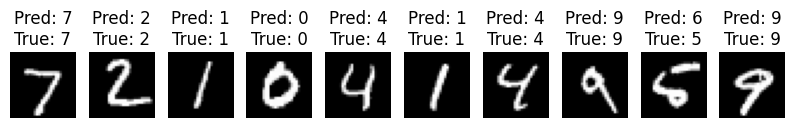

In [8]:
# Initialize and train the model
model = LogisticRegression(learning_rate=1e-5, iterations=200)
model.train(X_train, Y_train, X_test, Y_test)

# Save the model weights
model.save_model("logistic_regression_weights.h5")

# Test the model
predictions = model.test(X_test, Y_test)

# Visualize predictions
model.visualize_predictions(X_test, Y_test, predictions, num_images=10)